In [1]:
# !pip install autokeras


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
logging.getLogger('tensorflow').disabled = True

import autokeras as ak

import plotly.express as px
import copy 
import os
import json

from mylib import plot_roc, plot_pr_curve, plot_roc_train_test, plot_pr_train_test, hyper_table, predic_error_analysis, plot_pr_multi_class

## A Simple Example
The first step is to prepare your data. Here we use the [Titanic
dataset](https://www.kaggle.com/c/titanic) as an example.


In [3]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

First, let's try to visualize every feature of the training dataset, and color everything by the label.

In [4]:
x_train = pd.read_csv(train_file_path)
df = copy.deepcopy(x_train)
y_train = x_train.pop("survived")

display(df)
features = ["survived", "sex",'age', 'n_siblings_spouses', 'parch','fare', 'class', 'deck', 'embark_town', 'alone']
fig = px.scatter_matrix(df, dimensions=features, color="survived")
fig.update_traces(diagonal_visible=True)
fig.update_layout(width=1200, height=900)
fig.show()

survived     sex   age  n_siblings_spouses  parch     fare   class  \
0           0    male  22.0                   1      0   7.2500   Third   
1           1  female  38.0                   1      0  71.2833   First   
2           1  female  26.0                   0      0   7.9250   Third   
3           1  female  35.0                   1      0  53.1000   First   
4           0    male  28.0                   0      0   8.4583   Third   
..        ...     ...   ...                 ...    ...      ...     ...   
622         0    male  28.0                   0      0  10.5000  Second   
623         0    male  25.0                   0      0   7.0500   Third   
624         1  female  19.0                   0      0  30.0000   First   
625         0  female  28.0                   1      2  23.4500   Third   
626         0    male  32.0                   0      0   7.7500   Third   

        deck  embark_town alone  
0    unknown  Southampton     n  
1          C    Cherbourg     n  
2    unknown  Southampton     y  
3          C  Southampton     n  
4    unknown   Queenstown     y  
..       ...          ...   ...  
622  unknown  Southampton     y  
623  unknown  Southampton     y  
624        B  Southampton     y  
625  unknown  Southampton     n  
626  unknown   Queenstown     y  

[627 rows x 10 columns]

The second step is to run the
[StructuredDataClassifier](/structured_data_classifier).
As a quick demo, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [5]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    overwrite=True, max_trials=3
)  # It tries 3 different models.
# Feed the structured data classifier with training data.
clf.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "survived",
    epochs=10,
)
# Predict with the best model.
predicted_y = clf.predict(test_file_path)
# Evaluate the best model with testing data.
print(clf.evaluate(test_file_path, "survived"))

display(hyper_table())

Trial 3 Complete [00h 00m 02s]
val_accuracy: 0.7217391133308411

Best val_accuracy So Far: 0.8695651888847351
Total elapsed time: 00h 00m 08s
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.7540 - accuracy: 0.4176
Epoch 2/10
20/20 [==============================] - 0s 960us/step - loss: 0.6629 - accuracy: 0.5669
Epoch 3/10
20/20 [==============================] - 0s 951us/step - loss: 0.5937 - accuracy: 0.7596
Epoch 4/10
20/20 [==============================] - 0s 986us/step - loss: 0.5364 - accuracy: 0.7956
Epoch 5/10
20/20 [==============================] - 0s 968us/step - loss: 0.4893 - accuracy: 0.8050
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.8175
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.8104
Epoch 8/10
20/20 [==============================] - 0s 957us/step - loss: 0.4315 - accuracy: 0.8169
Epoch 9/10
20/20 [==============================] - 0s 1ms/step 

trial#1   trial#2  \
structured_data_block_1/normalize                       True     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/units_1             32        16   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.852174  0.721739   

                                                     trial#3  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/units_1             16  
classification_head_1/dropout                              0  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.869565

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16)                0     

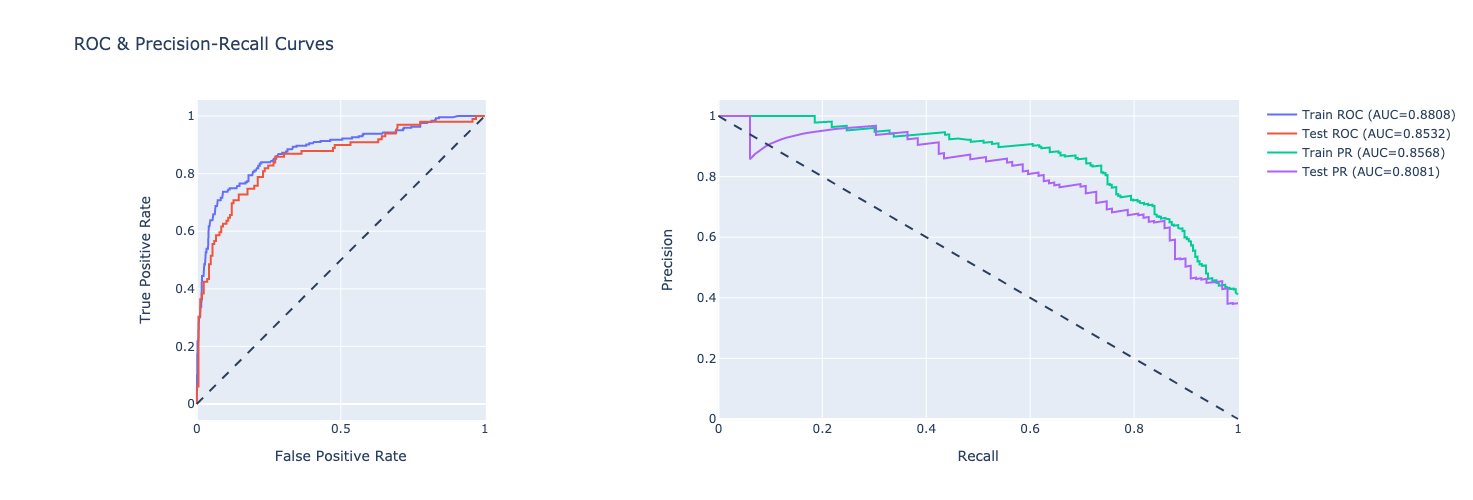

In [6]:
# Preparing testing data.
x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

#plot_roc(y_test, y_score)
#plot_pr_curve(y_test, y_score)
#plot_roc_train_test(y_train, y_score_train, y_test, y_score)

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

## Data Format
The AutoKeras StructuredDataClassifier is quite flexible for the data format.

The example above shows how to use the CSV files directly. Besides CSV files,
it also supports numpy.ndarray, pandas.DataFrame or [tf.data.Dataset](
https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable). The
data should be two-dimensional with numerical or categorical values.

For the classification labels,
AutoKeras accepts both plain labels, i.e. strings or integers, and one-hot encoded
encoded labels, i.e. vectors of 0s and 1s.
The labels can be numpy.ndarray, pandas.DataFrame, or pandas.Series.

The following examples show how the data can be prepared with numpy.ndarray,
pandas.DataFrame, and tensorflow.data.Dataset.


In [7]:
# x_train as pandas.DataFrame, y_train as pandas.Series
x_train = pd.read_csv(train_file_path)
print(type(x_train))  # pandas.DataFrame
y_train = x_train.pop("survived")
print(type(y_train))  # pandas.Series

# You can also use pandas.DataFrame for y_train.
y_train = pd.DataFrame(y_train)
print(type(y_train))  # pandas.DataFrame

# You can also use numpy.ndarray for x_train and y_train.
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
print(type(x_train))  # numpy.ndarray
print(type(y_train))  # numpy.ndarray

# Preparing testing data.
x_test = pd.read_csv(test_file_path)
y_test = x_test.pop("survived")

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
# It tries 10 different models.
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=10)
# Feed the structured data classifier with training data.
clf.fit(x_train, y_train, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))
display(hyper_table())

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.747826099395752

Best val_accuracy So Far: 0.8782608509063721
Total elapsed time: 00h 00m 20s
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5817
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6351 - accuracy: 0.6693
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5923 - accuracy: 0.6981
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5742 - accuracy: 0.7352
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5274 - accuracy: 0.7612
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4966 - accuracy: 0.7573
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4816 - accuracy: 0.8017
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.8140
Epoch 9/10
20/20 [==============================] - 0s 992us/step - loss: 

trial#1   trial#2  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            16        32   
structured_data_block_1/dense_block_1/dropout          0.25         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0      0.25   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.86087  0.843478   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam       sgd   
learning_rate                                          2e-05     0.001   
score                                               0.513043  0.347826   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0      0.25   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0      0.25   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.852174  0.843478   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0      0.25   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.86087  0.878261   

                                                     trial#9  trial#10  
structured_data_block_1/normalize                       True     False  
structured_data_block_1/dense_block_1/use_batch...     False     False  
structured_data_block_1/dense_block_1/num_layers           2         2  
structured_data_block_1/dense_block_1/units_0             32        32  
structured_data_block_1/dense_block_1/dropout           0.25         0  
structured_data_block_1/dense_block_1/units_1             32        32  
classification_head_1/dropout                              0         0  
optimizer                                               adam      adam  
learning_rate                                         0.0001     0.001  
score                                               0.747826  0.713043

9/9 [==============================] - 0s 902us/step - loss: 0.4431 - accuracy: 0.8030
[0.44313135743141174, 0.8030303120613098]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0        

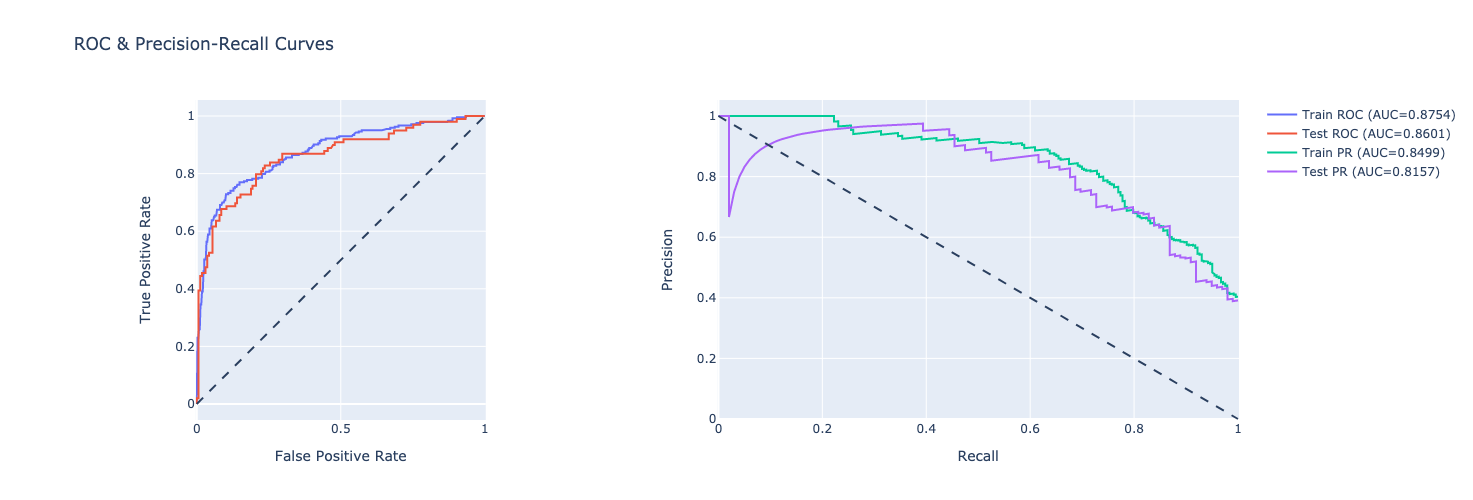

In [9]:
print(clf.evaluate(x_test, y_test))

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

The following code shows how to convert numpy.ndarray to tf.data.Dataset.


In [10]:
train_set = tf.data.Dataset.from_tensor_slices((x_train.astype(np.unicode), y_train))
test_set = tf.data.Dataset.from_tensor_slices(
    (x_test.to_numpy().astype(np.unicode), y_test)
)

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=3)
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(test_set)
# Evaluate the best model with testing data.
print(clf.evaluate(test_set))


Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.8695651888847351

Best val_accuracy So Far: 0.8782608509063721
Total elapsed time: 00h 00m 08s
Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 0.6775 - accuracy: 0.5475
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5835 - accuracy: 0.7491
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 0.5228 - accuracy: 0.7686
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4802 - accuracy: 0.7798
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4552 - accuracy: 0.8044
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.8044
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.8067
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8073
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 0.

You can also specify the column names and types for the data as follows.  The `column_names` is optional if the training data already have the column names, e.g.  pandas.DataFrame, CSV file.  Any column, whose type is not specified will be inferred from the training data.


In [11]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    column_names=[
        "sex",
        "age",
        "n_siblings_spouses",
        "parch",
        "fare",
        "class",
        "deck",
        "embark_town",
        "alone",
    ],
    column_types={"sex": "categorical", "fare": "numerical"},
    max_trials=10,  # It tries 10 different models.
    overwrite=True,
)


## Validation Data
By default, AutoKeras use the last 20% of training data as validation data.  As
shown in the example below, you can use `validation_split` to specify the
percentage.


In [12]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
    epochs=10,
)
display(hyper_table())

Trial 10 Complete [00h 00m 02s]
val_accuracy: 0.8554216623306274

Best val_accuracy So Far: 0.8795180916786194
Total elapsed time: 00h 00m 21s
Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6542 - accuracy: 0.6264
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5862 - accuracy: 0.7142
Epoch 3/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.7555
Epoch 4/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5110 - accuracy: 0.7670
Epoch 5/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4846 - accuracy: 0.7774
Epoch 6/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4635 - accuracy: 0.7825
Epoch 7/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.7712
Epoch 8/10
20/20 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.8142
Epoch 9/10
20/20 [==============================] - 0s 1ms/step - loss: 0

trial#1   trial#2  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            16        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.86747  0.879518   
structured_data_block_1/dense_block_1/units_2           NaN       NaN   

                                                     trial#3  trial#4  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1            256       32   
classification_head_1/dropout                              0     0.25   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.855422  0.86747   
structured_data_block_1/dense_block_1/units_2             16      NaN   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                       True     False   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0            512        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.855422  0.746988   
structured_data_block_1/dense_block_1/units_2             64       NaN   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          2e-05     0.001   
score                                               0.373494  0.855422   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   

                                                     trial#9 trial#10  
structured_data_block_1/normalize                       True     True  
structured_data_block_1/dense_block_1/use_batch...     False     True  
structured_data_block_1/dense_block_1/num_layers           3        2  
structured_data_block_1/dense_block_1/units_0             32       32  
structured_data_block_1/dense_block_1/dropout              0        0  
structured_data_block_1/dense_block_1/units_1             32       32  
classification_h

You can also use your own validation set
instead of splitting it from the training data with `validation_data`.


In [13]:
split = 500
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]
clf.fit(
    x_train,
    y_train,
    # Use your own validation set.
    validation_data=(x_val, y_val),
    epochs=10,
)

## Customized Search Space
For advanced users, you may customize your search space by using
[AutoModel](/auto_model/#automodel-class) instead of
[StructuredDataClassifier](/structured_data_classifier). You can configure the
[StructuredDataBlock](/block/#structureddatablock-class) for some high-level
configurations, e.g., `categorical_encoding` for whether to use the
[CategoricalToNumerical](/block/#categoricaltonumerical-class). You can also do
not specify these arguments, which would leave the different choices to be
tuned automatically. See the following example for detail.


Trial 3 Complete [00h 00m 02s]
val_loss: 0.4671719968318939

Best val_loss So Far: 0.4671719968318939
Total elapsed time: 00h 00m 06s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 0.7706 - accuracy: 0.4824
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.5955
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.6367
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5903 - accuracy: 0.7275
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5633 - accuracy: 0.7431
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5540 - accuracy: 0.7453
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.5184 - accuracy: 0.7798
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.7902
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss: 0.4830 - a

trial#1   trial#2  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                            0.5       0.5   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.528161  0.467172   

                                                     trial#3  
structured_data_block_1/normalize                      False  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/units_0             32  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_1             32  
classification_head_1/dropout                              0  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.547192

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense (Dense)                (None, 32)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

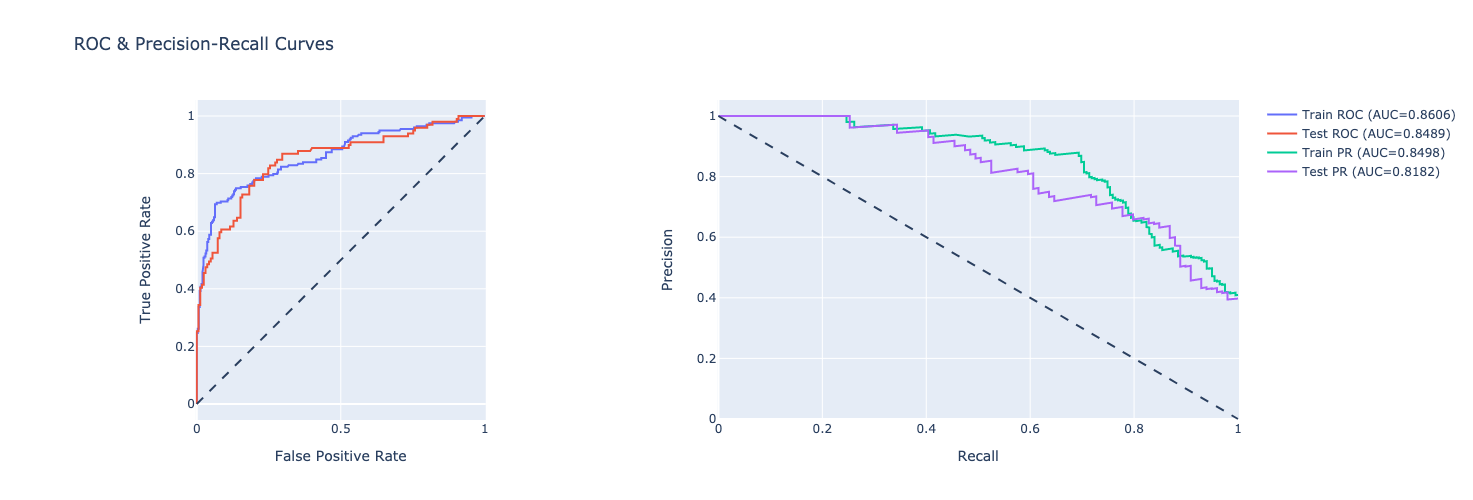

In [14]:

input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock(categorical_encoding=True)(input_node)
#output_node = ak.DenseBlock(num_layers=1, num_units=64, use_batchnorm=None, dropout=None)(output_node)
#output_node = ak.DenseBlock(num_layers=1, num_units=32, use_batchnorm=True, dropout=0.5)(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)
clf.fit(x_train, y_train, epochs=10)
clf.evaluate(x_test, y_test)

display(hyper_table('auto_model'))

model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

The usage of [AutoModel](/auto_model/#automodel-class) is similar to the
[functional API](https://www.tensorflow.org/guide/keras/functional) of Keras.
Basically, you are building a graph, whose edges are blocks and the nodes are
intermediate outputs of blocks.
To add an edge from `input_node` to `output_node` with
`output_node = ak.[some_block]([block_args])(input_node)`.

You can even also use more fine grained blocks to customize the search space even
further. See the following example.


In [15]:
input_node = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=10
)
clf.fit(x_train, y_train, epochs=10)
clf.evaluate(x_test, y_test)
display(hyper_table('auto_model'))

Trial 10 Complete [00h 00m 02s]
val_loss: 0.48918992280960083

Best val_loss So Far: 0.48918992280960083
Total elapsed time: 00h 00m 20s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 2.3124 - accuracy: 0.4516
Epoch 2/10
16/16 [==============================] - 0s 1ms/step - loss: 1.1476 - accuracy: 0.6319
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 1.0104 - accuracy: 0.6290
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.8494 - accuracy: 0.5624
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.7995 - accuracy: 0.6625
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.7135 - accuracy: 0.6548
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6923 - accuracy: 0.6411
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.6387
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6795 

trial#1   trial#2   trial#3   trial#4  \
dense_block_2/use_batchnorm      False     False     False     False   
dense_block_2/num_layers             3         2         2         2   
dense_block_2/units_0               64        32        32        32   
dense_block_2/dropout                0         0         0         0   
dense_block_2/units_1               32        32        64        32   
classification_head_1/dropout     0.25       0.5         0      0.25   
optimizer                         adam      adam      adam      adam   
learning_rate                    0.001     0.001     0.001      0.01   
dense_block_2/units_2               32       NaN       NaN       NaN   
score                          0.48919  0.533665  0.530485  0.544992   

                                trial#5   trial#6            trial#7  \
dense_block_2/use_batchnorm       False     False              False   
dense_block_2/num_layers              2         2                  2   
dense_block_2/units_0                32        32                 32   
dense_block_2/dropout                 0         0                  0   
dense_block_2/units_1                16        32                 32   
classification_head_1/dropout         0      0.25                  0   
optimizer                          adam      adam  adam_weight_decay   
learning_rate                     0.001     0.001              0.001   
dense_block_2/units_2               NaN       NaN                NaN   
score                          0.529154  0.511578           0.545432   

                                trial#8   trial#9  trial#10  
dense_block_2/use_batchnorm        True     False     False  
dense_block_2/num_layers              2         2         2  
dense_block_2/units_0                32        32        32  
dense_block_2/dropout                 0         0         0  
dense_block_2/units_1                32        32        32  
classification_head_1/dropout         0         0         0  
optimizer                          adam      adam      adam  
learning_rate                     0.001     0.001     0.001  
dense_block_2/units_2               NaN       NaN       NaN  
score                          0.572587  0.526275  0.546741

You can also export the best model found by AutoKeras as a Keras Model.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                640       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056  

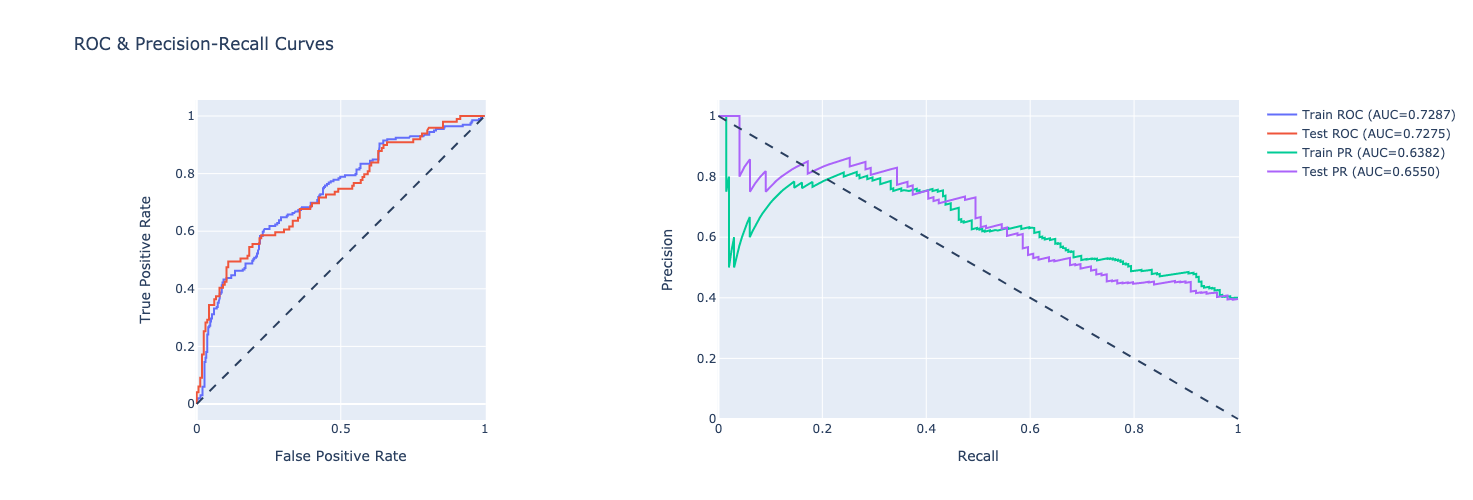

In [16]:
model = clf.export_model()
model.summary()

y_score = model.predict(x_test.astype(np.unicode))
y_score_train = model.predict(x_train.astype(np.unicode))

plot_pr_train_test(y_train, y_score_train, y_test, y_score)

In [17]:
print(x_train.dtype)
# numpy array in object (mixed type) is not supported.
# convert it to unicode.
y_predict_score = model.predict(x_train.astype(np.unicode))

object


In [18]:
Y_Scores = []
Y_Scores_train = []
Accuracies = []
Accuracies_train = []
Hyper_dfs = []
for it in range(5,16):
    # It tries 30 different models.
    clf = ak.StructuredDataClassifier(overwrite=True, max_trials=it)
    # Feed the structured data classifier with training data.
    clf.fit(x_train, y_train, epochs=10)
    # Predict with the best model.
    predicted_y = clf.predict(x_test)
    # Evaluate the best model with testing data.
    Accuracies.append(clf.evaluate(x_test, y_test)[1])
    Accuracies_train.append(clf.evaluate(x_train, y_train)[1])

    Hyper_dfs.append(hyper_table())
    
    model = clf.export_model()
    y_score = model.predict(x_test.astype(np.unicode))
    Y_Scores.append(y_score)
    y_score_train = model.predict(x_train.astype(np.unicode))
    Y_Scores_train.append(y_score_train)

Trial 15 Complete [00h 00m 02s]
val_accuracy: 0.8095238208770752

Best val_accuracy So Far: 0.8095238208770752
Total elapsed time: 00h 00m 31s
Epoch 1/10
16/16 [==============================] - 0s 1ms/step - loss: 1.7751 - accuracy: 0.4152
Epoch 2/10
16/16 [==============================] - 0s 982us/step - loss: 0.8051 - accuracy: 0.6180
Epoch 3/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6554 - accuracy: 0.6593
Epoch 4/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6570 - accuracy: 0.6220
Epoch 5/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6512 - accuracy: 0.6572
Epoch 6/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6365 - accuracy: 0.6531
Epoch 7/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6288 - accuracy: 0.6715
Epoch 8/10
16/16 [==============================] - 0s 1ms/step - loss: 0.6311 - accuracy: 0.6697
Epoch 9/10
16/16 [==============================] - 0s 1ms/step - loss:

In [19]:
Accuracies

[0.689393937587738,
 0.7765151262283325,
 0.6969696879386902,
 0.7803030014038086,
 0.7310606241226196,
 0.7878788113594055,
 0.7840909361839294,
 0.7803030014038086,
 0.7878788113594055,
 0.7765151262283325,
 0.6780303120613098]

In [20]:
Accuracies_train

[0.6399999856948853,
 0.8100000023841858,
 0.6899999976158142,
 0.8119999766349792,
 0.7160000205039978,
 0.8220000267028809,
 0.8199999928474426,
 0.8159999847412109,
 0.8159999847412109,
 0.8259999752044678,
 0.6840000152587891]

* ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
* Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
* ROC curves are appropriate when the __observations are balanced between each class__, whereas precision-recall curves are appropriate for __imbalanced datasets__.

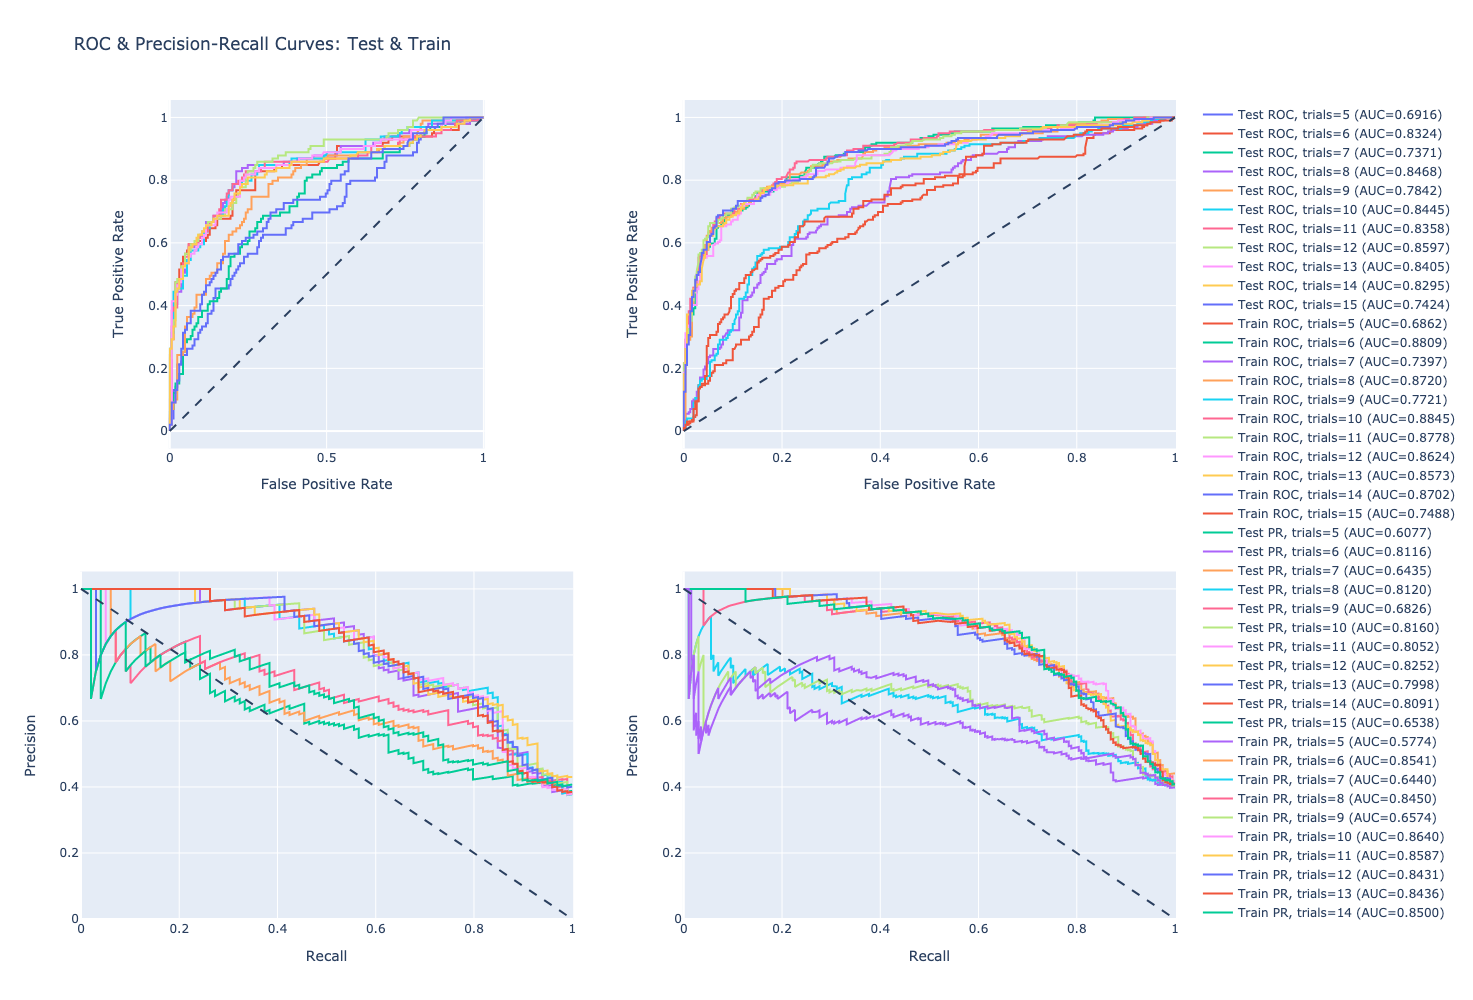

trial#1 trial#2  \
structured_data_block_1/normalize                     True    True   
structured_data_block_1/dense_block_1/use_batch...    True   False   
structured_data_block_1/dense_block_1/num_layers         2       2   
structured_data_block_1/dense_block_1/units_0           32      32   
structured_data_block_1/dense_block_1/dropout            0       0   
structured_data_block_1/dense_block_1/units_1           32      32   
classification_head_1/dropout                            0       0   
optimizer                                             adam    adam   
learning_rate                                        0.001   0.001   
score                                                 0.75    0.75   
structured_data_block_1/dense_block_1/units_2          NaN     NaN   

                                                              trial#3  \
structured_data_block_1/normalize                               False   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    3   
structured_data_block_1/dense_block_1/units_0                    1024   
structured_data_block_1/dense_block_1/dropout                     0.5   
structured_data_block_1/dense_block_1/units_1                     128   
classification_head_1/dropout                                     0.5   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                        0.797619   
structured_data_block_1/dense_block_1/units_2                      32   

                                                    trial#4   trial#5  
structured_data_block_1/normalize                      True      True  
structured_data_block_1/dense_block_1/use_batch...    False     False  
structured_data_block_1/dense_block_1/num_layers          1         2  
structured_data_block_1/dense_block_1/units_0            32        32  
structured_data_block_1/dense_block_1/dropout             0         0  
structured_data_block_1/dense_block_1/units_1            32        32  
classification_head_1/dropout                             0      0.25  
optimizer                                              adam      adam  
learning_rate                                         0.001     0.001  
score                                               0.72619  0.738095  
structured_data_block_1/dense_block_1/units_2           NaN       NaN

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam       sgd   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.333333   

                                                    trial#3  trial#4  trial#5  \
structured_data_block_1/normalize                      True     True     True   
structured_data_block_1/dense_block_1/use_batch...    False    False    False   
structured_data_block_1/dense_block_1/num_layers          2        2        2   
structured_data_block_1/dense_block_1/units_0            32       32       16   
structured_data_block_1/dense_block_1/dropout             0        0        0   
structured_data_block_1/dense_block_1/units_1            32       16       32   
classification_head_1/dropout                             0        0        0   
optimizer                                              adam     adam     adam   
learning_rate                                         0.001    0.001    0.001   
score                                               0.77381  0.77381  0.77381   

                                                     trial#6  
structured_data_block_1/normalize                       True  
structured_data_block_1/dense_block_1/use_batch...     False  
structured_data_block_1/dense_block_1/num_layers           2  
structured_data_block_1/dense_block_1/units_0           1024  
structured_data_block_1/dense_block_1/dropout              0  
structured_data_block_1/dense_block_1/units_1             32  
classification_head_1/dropout                              0  
optimizer                                               adam  
learning_rate                                          0.001  
score                                               0.761905

trial#1   trial#2  \
structured_data_block_1/normalize                    False      True   
structured_data_block_1/dense_block_1/use_batch...   False     False   
structured_data_block_1/dense_block_1/num_layers         2         2   
structured_data_block_1/dense_block_1/units_0           32        32   
structured_data_block_1/dense_block_1/dropout         0.25         0   
structured_data_block_1/dense_block_1/units_1           64        64   
classification_head_1/dropout                            0         0   
optimizer                                             adam      adam   
learning_rate                                        0.001     0.001   
score                                                 0.75  0.797619   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...      True     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             64        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.809524  0.761905   

                                                     trial#5  trial#6  trial#7  
structured_data_block_1/normalize                      False     True    False  
structured_data_block_1/dense_block_1/use_batch...     False    False    False  
structured_data_block_1/dense_block_1/num_layers           2        2        2  
structured_data_block_1/dense_block_1/units_0             32       32       32  
structured_data_block_1/dense_block_1/dropout              0        0        0  
structured_data_block_1/dense_block_1/units_1             64       16       64  
classification_head_1/dropout                              0        0      0.5  
optimizer                                               adam     adam     adam  
learning_rate                                          0.001    0.001    0.001  
score                                               0.809524  0.77381  0.77381

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         3   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                         0.0001     0.001   
structured_data_block_1/dense_block_1/units_2             32        32   
score                                               0.690476  0.797619   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001    0.0001   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   
score                                               0.797619  0.666667   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   
score                                               0.797619  0.785714   

                                                     trial#7   trial#8  
structured_data_block_1/normalize                       True      True  
structured_data_block_1/dense_block_1/use_batch...     False     False  
structured_data_block_1/dense_block_1/num_layers           2         2  
structured_data_block_1/dense_block_1/units_0             32        32  
structured_data_block_1/dense_block_1/dropout              0         0  
structured_data_block_1/dense_block_1/units_1             32        32  
classification_head_1/dropout                           0.25         0  
optimizer                                               adam      adam  
learning_rate                                          0.001     0.001  
structured_data_block_1/dense_block_1/units_2            512       NaN  
score                                               0.785714  0.809524

trial#1  \
structured_data_block_1/normalize                               False   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                            0.75   

                                                    trial#2   trial#3  \
structured_data_block_1/normalize                      True     False   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         1   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.797619   

                                                     trial#4   trial#5  \
structured_data_block_1/normalize                      False     False   
structured_data_block_1/dense_block_1/use_batch...      True      True   
structured_data_block_1/dense_block_1/num_layers           1         2   
structured_data_block_1/dense_block_1/units_0             16        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1            128        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.738095  0.714286   

                                                     trial#6   trial#7  \
structured_data_block_1/normalize                       True     False   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                            0.5         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.761905  0.809524   

                                                     trial#8   trial#9  
structured_data_block_1/normalize                       True     False  
structured_data_block_1/dense_block_1/use_batch...     False     False  
structured_data_block_1/dense_block_1/num_layers           2         2  
structured_data_block_1/dense_block_1/units_0             32        32  
structured_data_block_1/dense_block_1/dropout            0.5         0  
structured_data_block_1/dense_block_1/units_1             32        32  
classification_head_1/dropout                              0         0  
optimizer                                               adam       sgd  
learning_rate                                          0.001     0.001  
score                                               0.738095  0.809524

trial#1   trial#2  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         3   
structured_data_block_1/dense_block_1/units_0           512        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.761905   
structured_data_block_1/dense_block_1/units_2           NaN        32   

                                                    trial#3   trial#4  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          1         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0      0.25   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.797619   
structured_data_block_1/dense_block_1/units_2            16       512   

                                                    trial#5  \
structured_data_block_1/normalize                      True   
structured_data_block_1/dense_block_1/use_batch...    False   
structured_data_block_1/dense_block_1/num_layers          2   
structured_data_block_1/dense_block_1/units_0            32   
structured_data_block_1/dense_block_1/dropout             0   
structured_data_block_1/dense_block_1/units_1            32   
classification_head_1/dropout                             0   
optimizer                                              adam   
learning_rate                                         0.001   
score                                               0.77381   
structured_data_block_1/dense_block_1/units_2            16   

                                                              trial#6  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                        0.761905   
structured_data_block_1/dense_block_1/units_2                     256   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam  

trial#1   trial#2  \
structured_data_block_1/normalize                     True      True   
structured_data_block_1/dense_block_1/num_layers         2         2   
structured_data_block_1/dense_block_1/use_batch...   False     False   
structured_data_block_1/dense_block_1/dropout            0         0   
structured_data_block_1/dense_block_1/units_0           32        32   
structured_data_block_1/dense_block_1/units_1           32        32   
classification_head_1/dropout                            0      0.25   
optimizer                                             adam      adam   
learning_rate                                        0.001     0.001   
score                                                 0.75  0.797619   
structured_data_block_1/dense_block_1/units_2          NaN       256   

                                                     trial#3  trial#4  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                              0     0.25   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.809524  0.77381   
structured_data_block_1/dense_block_1/units_2             16      NaN   

                                                     trial#5  trial#6  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/use_batch...      True    False   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_0             32       32   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                           0.25      0.5   
optimizer                                               adam     adam   
learning_rate                                          0.001    0.001   
score                                               0.738095  0.72619   
structured_data_block_1/dense_block_1/units_2             16       16   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/use_batch...      True     False   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_0             32        64   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0      0.25   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.797619  0.761905   
structured_data_block_1/dense_block_1/units_2             16        16   

                                                     trial#9  trial#10  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/units_1            512        32   
classification_head_1/dro

trial#1   trial#2  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout          0.25         0   
structured_data_block_1/dense_block_1/units_1           512        32   
classification_head_1/dropout                             0         0   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.785714   
structured_data_block_1/dense_block_1/units_2           NaN       NaN   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0      0.25   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                            0.5         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.797619  0.833333   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   

                                                    trial#5  trial#6  \
structured_data_block_1/normalize                      True     True   
structured_data_block_1/dense_block_1/use_batch...    False    False   
structured_data_block_1/dense_block_1/num_layers          2        1   
structured_data_block_1/dense_block_1/units_0            32       32   
structured_data_block_1/dense_block_1/dropout           0.5     0.25   
structured_data_block_1/dense_block_1/units_1            32       32   
classification_head_1/dropout                             0        0   
optimizer                                              adam     adam   
learning_rate                                         0.001    0.001   
score                                               0.77381  0.72619   
structured_data_block_1/dense_block_1/units_2           NaN      NaN   

                                                              trial#7  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                    0.25   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score                                                            0.75   
structured_data_block_1/dense_block_1/units_2                     NaN   

                                                     trial#8   trial#9  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout           0.25         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/drop

trial#1   trial#2  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.785714   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         1   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                           0.25         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.785714   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   

                                                     trial#5   trial#6  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001      0.01   
score                                               0.785714  0.761905   
structured_data_block_1/dense_block_1/units_2            NaN       NaN   

                                                    trial#7   trial#8  \
structured_data_block_1/normalize                      True      True   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0            32        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            16        32   
classification_head_1/dropout                             0       0.5   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.821429   
structured_data_block_1/dense_block_1/units_2           NaN       NaN   

                                                     trial#9  trial#10  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         3   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             64     

trial#1  trial#2 trial#3  \
structured_data_block_1/normalize                      True     True    True   
structured_data_block_1/dense_block_1/use_batch...    False    False    True   
structured_data_block_1/dense_block_1/num_layers          2        2       2   
structured_data_block_1/dense_block_1/units_0            32       16      32   
structured_data_block_1/dense_block_1/dropout             0        0       0   
structured_data_block_1/dense_block_1/units_1            32       32      32   
classification_head_1/dropout                             0     0.25    0.25   
optimizer                                              adam     adam    adam   
learning_rate                                         0.001    0.001   0.001   
score                                               0.77381  0.72619    0.75   

                                                     trial#4   trial#5  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0       0.5   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.809524   

                                                    trial#6   trial#7  \
structured_data_block_1/normalize                      True     False   
structured_data_block_1/dense_block_1/use_batch...    False     False   
structured_data_block_1/dense_block_1/num_layers          2         2   
structured_data_block_1/dense_block_1/units_0          1024        32   
structured_data_block_1/dense_block_1/dropout             0         0   
structured_data_block_1/dense_block_1/units_1            32        32   
classification_head_1/dropout                          0.25      0.25   
optimizer                                              adam      adam   
learning_rate                                         0.001     0.001   
score                                               0.77381  0.797619   

                                                     trial#8  trial#9  \
structured_data_block_1/normalize                       True     True   
structured_data_block_1/dense_block_1/use_batch...     False    False   
structured_data_block_1/dense_block_1/num_layers           2        2   
structured_data_block_1/dense_block_1/units_0             32      256   
structured_data_block_1/dense_block_1/dropout              0        0   
structured_data_block_1/dense_block_1/units_1             32       32   
classification_head_1/dropout                           0.25        0   
optimizer                                               adam     adam   
learning_rate                                          2e-05    0.001   
score                                               0.404762  0.77381   

                                                             trial#10  \
structured_data_block_1/normalize                                True   
structured_data_block_1/dense_block_1/use_batch...              False   
structured_data_block_1/dense_block_1/num_layers                    2   
structured_data_block_1/dense_block_1/units_0                      32   
structured_data_block_1/dense_block_1/dropout                       0   
structured_data_block_1/dense_block_1/units_1                      32   
classification_head_1/dropout                                       0   
optimizer                                           adam_weight_decay   
learning_rate                                                   0.001   
score             

trial#1   trial#2  \
structured_data_block_1/normalize                      False     False   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32        32   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             64        32   
classification_head_1/dropout                              0      0.25   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.785714  0.809524   

                                                     trial#3   trial#4  \
structured_data_block_1/normalize                      False      True   
structured_data_block_1/dense_block_1/use_batch...      True     False   
structured_data_block_1/dense_block_1/num_layers           1         2   
structured_data_block_1/dense_block_1/units_0            512        32   
structured_data_block_1/dense_block_1/dropout           0.25       0.5   
structured_data_block_1/dense_block_1/units_1           1024        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          0.001     0.001   
score                                               0.809524  0.714286   

                                                     trial#5 trial#6  \
structured_data_block_1/normalize                      False    True   
structured_data_block_1/dense_block_1/use_batch...     False   False   
structured_data_block_1/dense_block_1/num_layers           2       2   
structured_data_block_1/dense_block_1/units_0             32      32   
structured_data_block_1/dense_block_1/dropout              0       0   
structured_data_block_1/dense_block_1/units_1           1024      32   
classification_head_1/dropout                              0     0.5   
optimizer                                               adam    adam   
learning_rate                                          0.001   0.001   
score                                               0.761905    0.75   

                                                     trial#7   trial#8  \
structured_data_block_1/normalize                       True      True   
structured_data_block_1/dense_block_1/use_batch...     False     False   
structured_data_block_1/dense_block_1/num_layers           2         2   
structured_data_block_1/dense_block_1/units_0             32       256   
structured_data_block_1/dense_block_1/dropout              0         0   
structured_data_block_1/dense_block_1/units_1             32        32   
classification_head_1/dropout                              0         0   
optimizer                                               adam      adam   
learning_rate                                          1e-05     0.001   
score                                               0.571429  0.785714   

                                                     trial#9  \
structured_data_block_1/normalize                       True   
structured_data_block_1/dense_block_1/use_batch...     False   
structured_data_block_1/dense_block_1/num_layers           2   
structured_data_block_1/dense_block_1/units_0             32   
structured_data_block_1/dense_block_1/dropout              0   
structured_data_block_1/dense_block_1/units_1             32   
classification_head_1/dropout                              0   
optimizer                                               adam   
learning_rate                                         0.0001   
score                                               0.654762   

                                                             trial#10  \
structured_data_block_1/normalize    

[None, None, None, None, None, None, None, None, None, None, None]

In [21]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from plotly.subplots import make_subplots

#fig = go.Figure()
fig = make_subplots(rows=2, cols=2)

# subplot 1: ROC curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1,
    row=1, col=1
)

for i in range(len(Y_Scores)):
    y_true = y_test
    y_score = Y_Scores[i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"Test ROC, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'), row=1,col=1)

fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
#fig.show()

# subplot 2: ROC curve Training data
#fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1,
    row=1,col=2
)

for i in range(len(Y_Scores_train)):
    y_true = y_train
    y_score = Y_Scores_train[i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"Train ROC, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'), row=1,col=2)

fig.update_xaxes(title_text="False Positive Rate", row=1, col=2)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=2)

# subplot 3: PR curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0, 
    row=2,col=1
)

for i in range(len(Y_Scores)):
    y_true = y_test
    y_score = Y_Scores[i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"Test PR, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=2,col=1)

fig.update_xaxes(title_text="Recall", row=2, col=1)
fig.update_yaxes(title_text="Precision", row=2, col=1)

# subplot 3: PR curve Testing data
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0, 
    row=2,col=2
)

for i in range(len(Y_Scores_train)):
    y_true = y_train
    y_score = Y_Scores_train[i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"Train PR, trials={i+5} (AUC={auc_score:.4f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'),row=2,col=2)

fig.update_xaxes(title_text="Recall", row=2, col=2)
fig.update_yaxes(title_text="Precision", row=2, col=2)


fig.update_layout(
    title=f'ROC & Precision-Recall Curves: Test & Train',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1000, height=1000
)
fig.show()

[display(d) for d in Hyper_dfs]